In [4]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from dataclasses import dataclass, field
from functools import cached_property
from tqdm import tqdm

sys.path.append("../src")
import intragenic_insertion_visualization

plt.style.use("../../config/DIT_HAP.mplstyle")
AX_WIDTH, AX_HEIGHT = plt.rcParams["figure.figsize"]
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# 1. Load data

In [5]:
@dataclass
class DataConfig:

    project_dir: Path = Path("../../results/HD_DIT_HAP_generationRAW")

    @cached_property
    def insertion_statistics(self) -> pd.DataFrame:
        return pd.read_csv(self.project_dir / "15_insertion_level_curve_fitting/insertion_level_fitting_statistics.tsv", index_col=[0,1,2,3], sep="\t")

    @cached_property
    def gene_statistics(self) -> pd.DataFrame:
        return pd.read_csv(self.project_dir / "17_gene_level_curve_fitting/gene_level_fitting_statistics.tsv", index_col=1, sep="\t")

    @cached_property
    def annotations(self) -> pd.DataFrame:
        return pd.read_csv(self.project_dir / "12_concatenated/annotations.tsv", index_col=[0,1,2,3], sep="\t")

    @cached_property
    def insertion_with_annotations(self) -> pd.DataFrame:
        return pd.merge(self.insertion_statistics, self.annotations, left_index=True, right_index=True, how="left")
    
    @cached_property
    def in_gene_insertions(self) -> pd.DataFrame:
        return self.insertion_with_annotations.query("Type != 'Intergenic region' and Distance_to_stop_codon > 4").copy()
    
    @property
    def output_dir(self) -> Path:
        return self.project_dir / "19_genes_with_domain_differences"

    def __post_init__(self):
        self.output_dir.mkdir(parents=True, exist_ok=True)

config = DataConfig()

# 2. Select genes with growth phenotypes

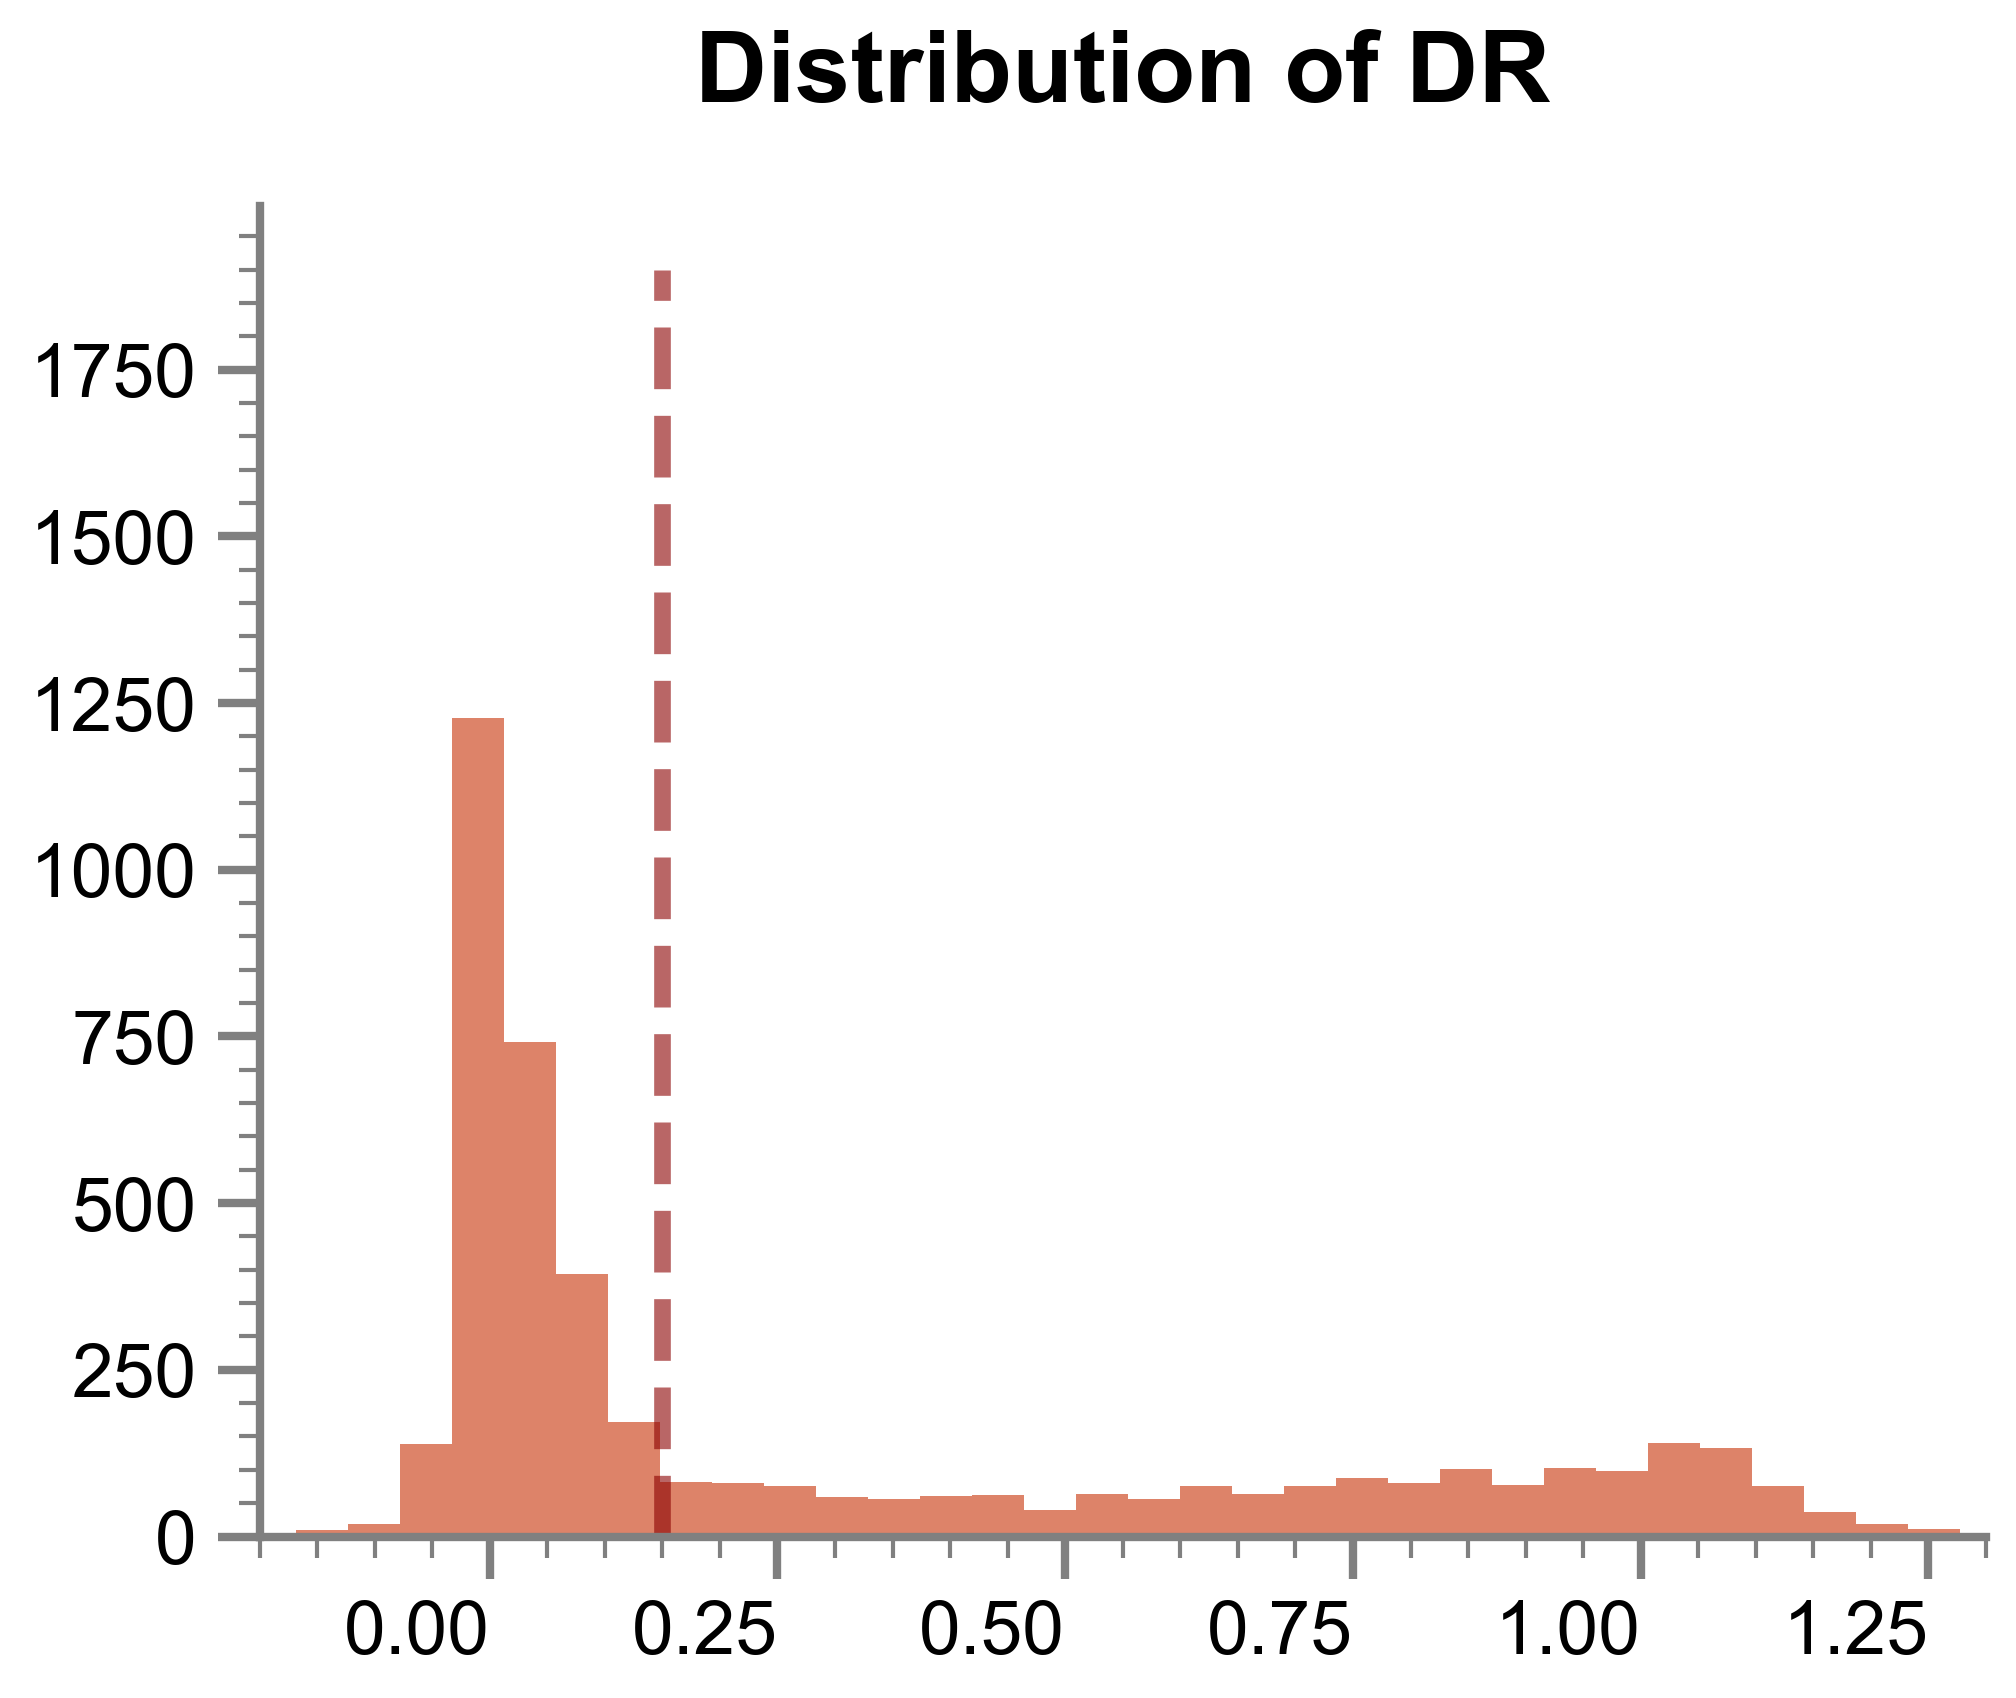

In [6]:
plt.hist(config.gene_statistics["um"], bins=50)
plt.xlim(-0.2,1.3)
plt.title("Distribution of DR")
plt.vlines(0.15, 0, 1900 , color="darkred", linestyle="--", alpha=0.6)
plt.show()
plt.close()

In [7]:
selected_genes = config.gene_statistics.query("um > 0.15").index.tolist()
print(len(selected_genes))

1811


# 3. Visualize the intragenic insertions for selected genes

Visualizing intragenic insertions:   0%|          | 9/1800 [00:03<12:32,  2.38it/s]  


KeyboardInterrupt: 

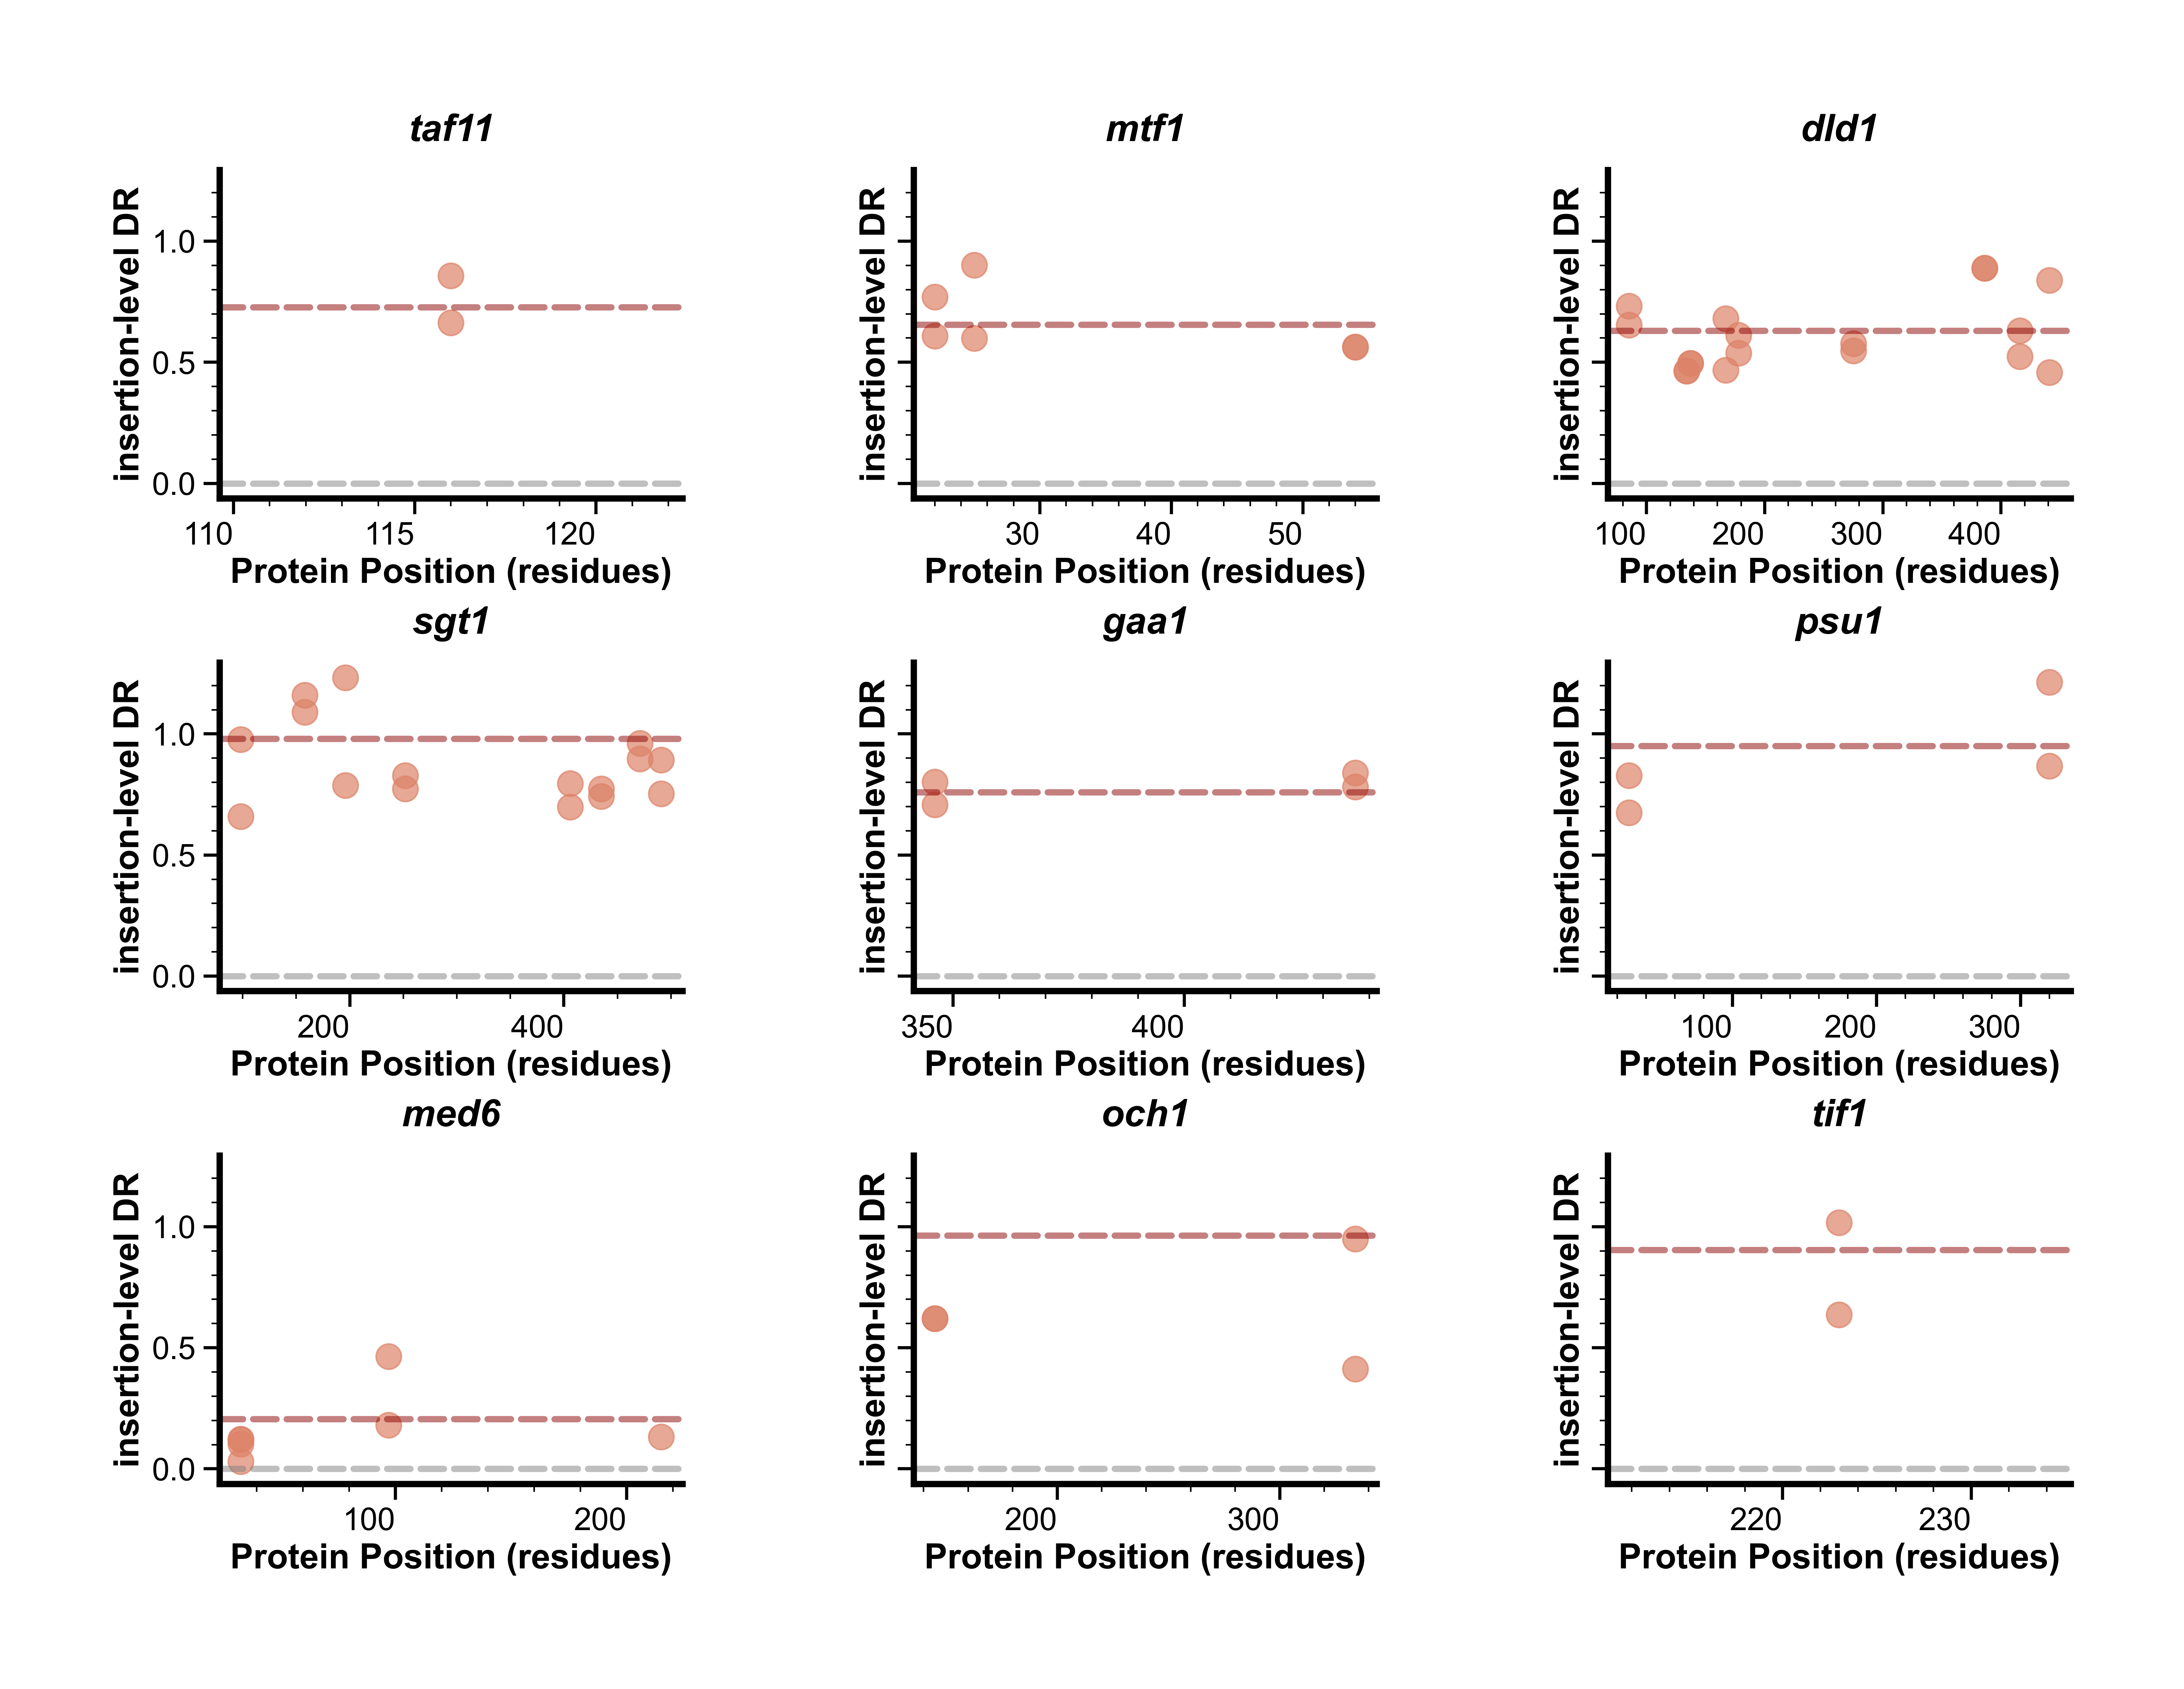

In [5]:
ROWS = 3
COLS = 3

with PdfPages(config.output_dir / "intragenic_insertions_for_genes_with_phenotypes.pdf") as pdf:
    with tqdm(range(0, len(selected_genes)), desc="Visualizing intragenic insertions") as pbar:
        for start in range(0, len(selected_genes), COLS * ROWS):
            end = min(start + COLS * ROWS, len(selected_genes))
            fig, axes = plt.subplots(ROWS, COLS, figsize=(7*COLS,5*ROWS), sharey=True)
            axes = axes.ravel()

            for i, gene in enumerate(selected_genes[start:end]):
                ax = axes[i]
                intragenic_insertion_visualization.intragenic_insertion_visualization(config.in_gene_insertions, config.gene_statistics, gene, COLORS[0], ax)
                pbar.update(1)
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close()
            

# 4.Example visualization

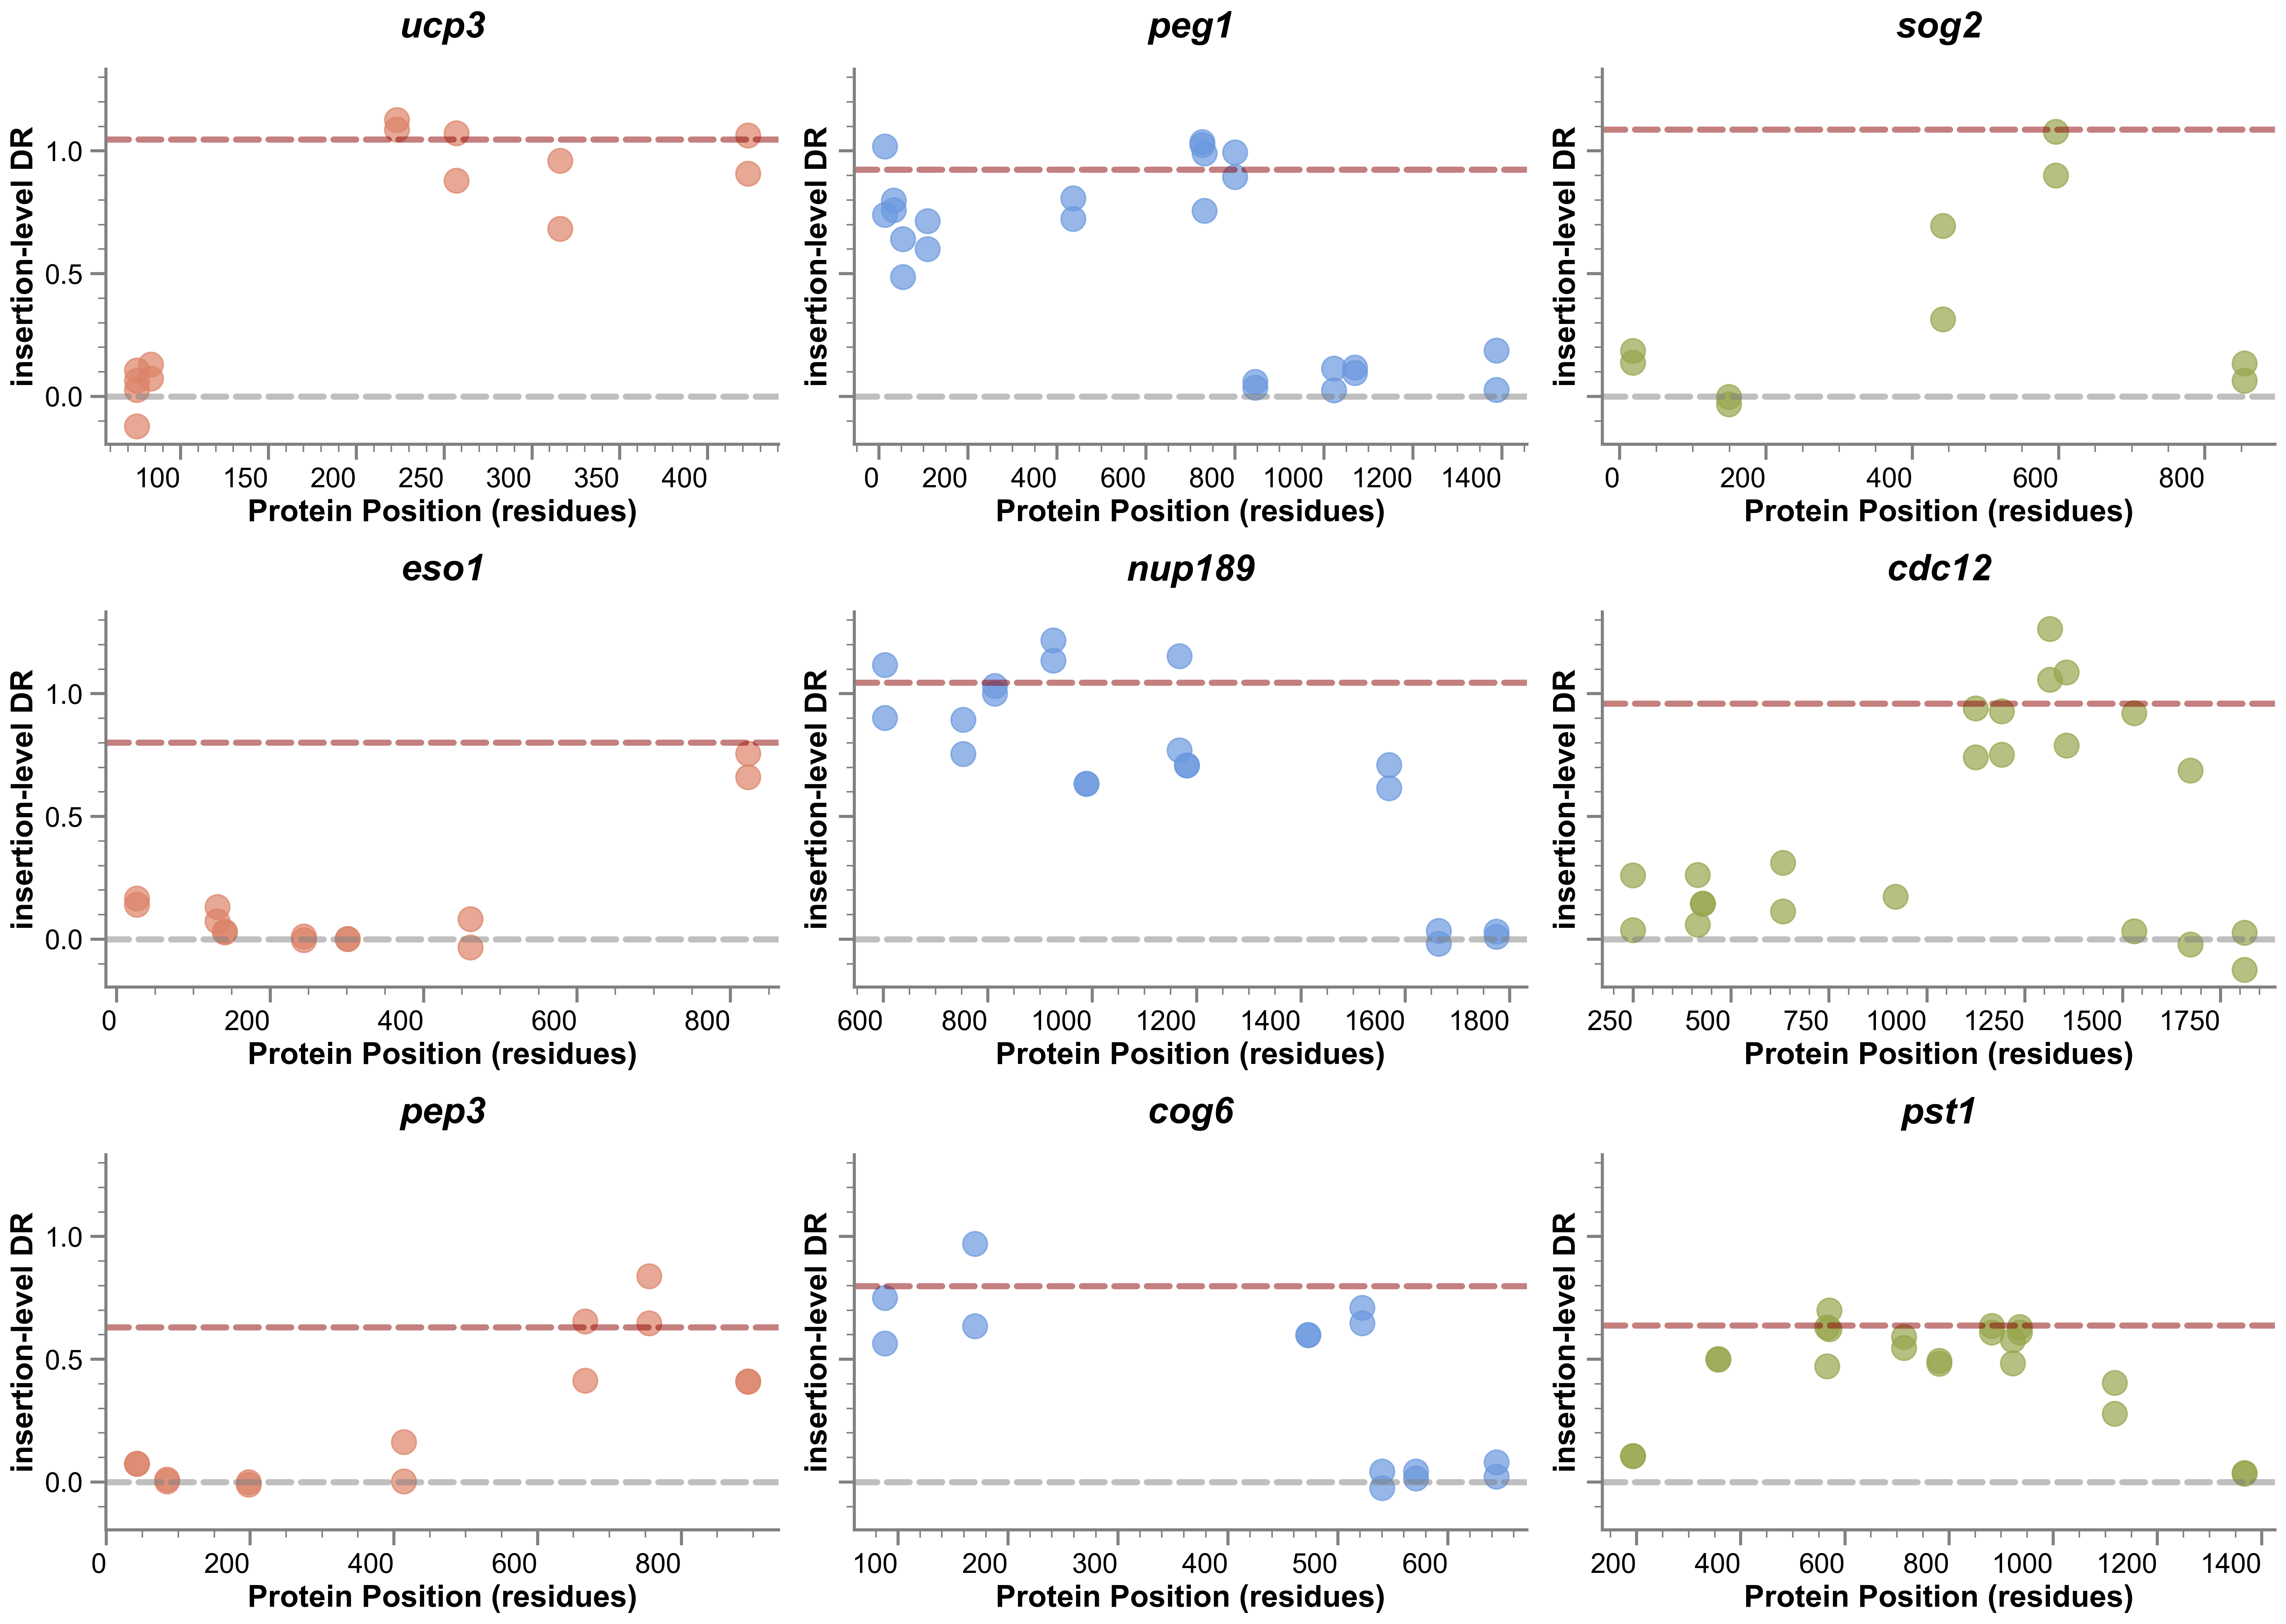

In [8]:
example_genes = {
    "Non-essential N terminus": ["ucp3","eso1","pep3"],
    "Non-essential C terminus": ["peg1","nup189","cog6"],
    "Non-essential N terminus and C terminus": ["sog2","cdc12","pst1"]
}

fig, axes = plt.subplots(3,3, figsize=(21,15), sharey=True)

for col, (title, gene_list) in enumerate(example_genes.items()):
    for row, gene in enumerate(gene_list):
        ax = axes[row, col]
        intragenic_insertion_visualization.intragenic_insertion_visualization(config.in_gene_insertions, config.gene_statistics, gene, COLORS[col], ax)

plt.tight_layout()
plt.savefig(config.output_dir / "intragenic_insertions_for_example_genes.pdf", dpi=300)
plt.show()
plt.close()

# 5. Analysis of the non-essential domains

## 5.1 Organize the data for visualization

In [3]:
non_essential_N_terminus = pd.read_excel("../../resources/non_esential_domain_candidates.xlsx", sheet_name="Non-essential N terminus")
non_essential_C_terminus = pd.read_excel("../../resources/non_esential_domain_candidates.xlsx", sheet_name="Non-essential C terminus")
non_essential_N_and_C_termini = pd.read_excel("../../resources/non_esential_domain_candidates.xlsx", sheet_name="Non-essential N and C termini")

concated_non_essential_N_terminus = pd.concat([non_essential_N_terminus, non_essential_N_and_C_termini[non_essential_N_terminus.columns.tolist()]], ignore_index=True)
concated_non_essential_C_terminus = pd.concat([non_essential_C_terminus, non_essential_N_and_C_termini[non_essential_C_terminus.columns.tolist()]], ignore_index=True)

In [4]:
coding_gene_info = pd.read_csv("../../resources/pombase_data/2025-09-01/genome_region/coding_gene_primary_transcripts.bed", sep="\t")
coding_gene_info = coding_gene_info[["Systematic ID", "Name", "#Chr", "Strand", "FYPOviability", "DeletionLibrary_essentiality", "ParentalRegion_start", "ParentalRegion_end", "ParentalRegion_length"]]
coding_gene_info.drop_duplicates(inplace=True)
coding_gene_info.rename(
    columns={
        "Systematic ID": "Systematic_ID",
        "Name": "Gene",
        "#Chr": "Chromosome",
        "ParentalRegion_start": "Start",
        "ParentalRegion_end": "End",
        "ParentalRegion_length": "Length"
    },
    inplace=True
)
protein_length = pd.read_csv("../../resources/pombase_data/2025-09-01/Protein_features/peptide_stats.tsv", sep="\t")[["Systematic_ID", "Residues"]]

In [5]:
def assign_domain_coordinates(df: pd.DataFrame, gene_info: pd.DataFrame, protein_length: pd.DataFrame) -> pd.DataFrame:
    """Assign domain coordinates to the dataframe."""
    df = df.merge(
        gene_info, on="Gene", how="left"
    ).merge(
        protein_length, on="Systematic_ID", how="left"
    )

    if "Affected N terminal residue (aa)" in df.columns:
        df["Affected residue (aa)"] = df["Affected N terminal residue (aa)"]
    elif "Affected C terminal residue (aa)" in df.columns:
        df["Affected residue (aa)"] = df["Affected C terminal residue (aa)"]
    else:
        raise ValueError("No affected residue column found in the dataframe.")

    df["AA_distance_to_start_codon"] = df["Affected residue (aa)"]
    df["AA_distance_to_stop_codon"] = df["Residues"] - df["Affected residue (aa)"]
    df["AA_fraction_to_start_codon"] = df["AA_distance_to_start_codon"] / df["Residues"]
    df["AA_fraction_to_stop_codon"] = df["AA_distance_to_stop_codon"] / df["Residues"]
    
    return df

In [6]:
annotated_non_essential_N_terminus = assign_domain_coordinates(concated_non_essential_N_terminus, coding_gene_info, protein_length)
annotated_non_essential_C_terminus = assign_domain_coordinates(concated_non_essential_C_terminus, coding_gene_info, protein_length)

## 5.2 Histogram of the fraction to the start/stop codon

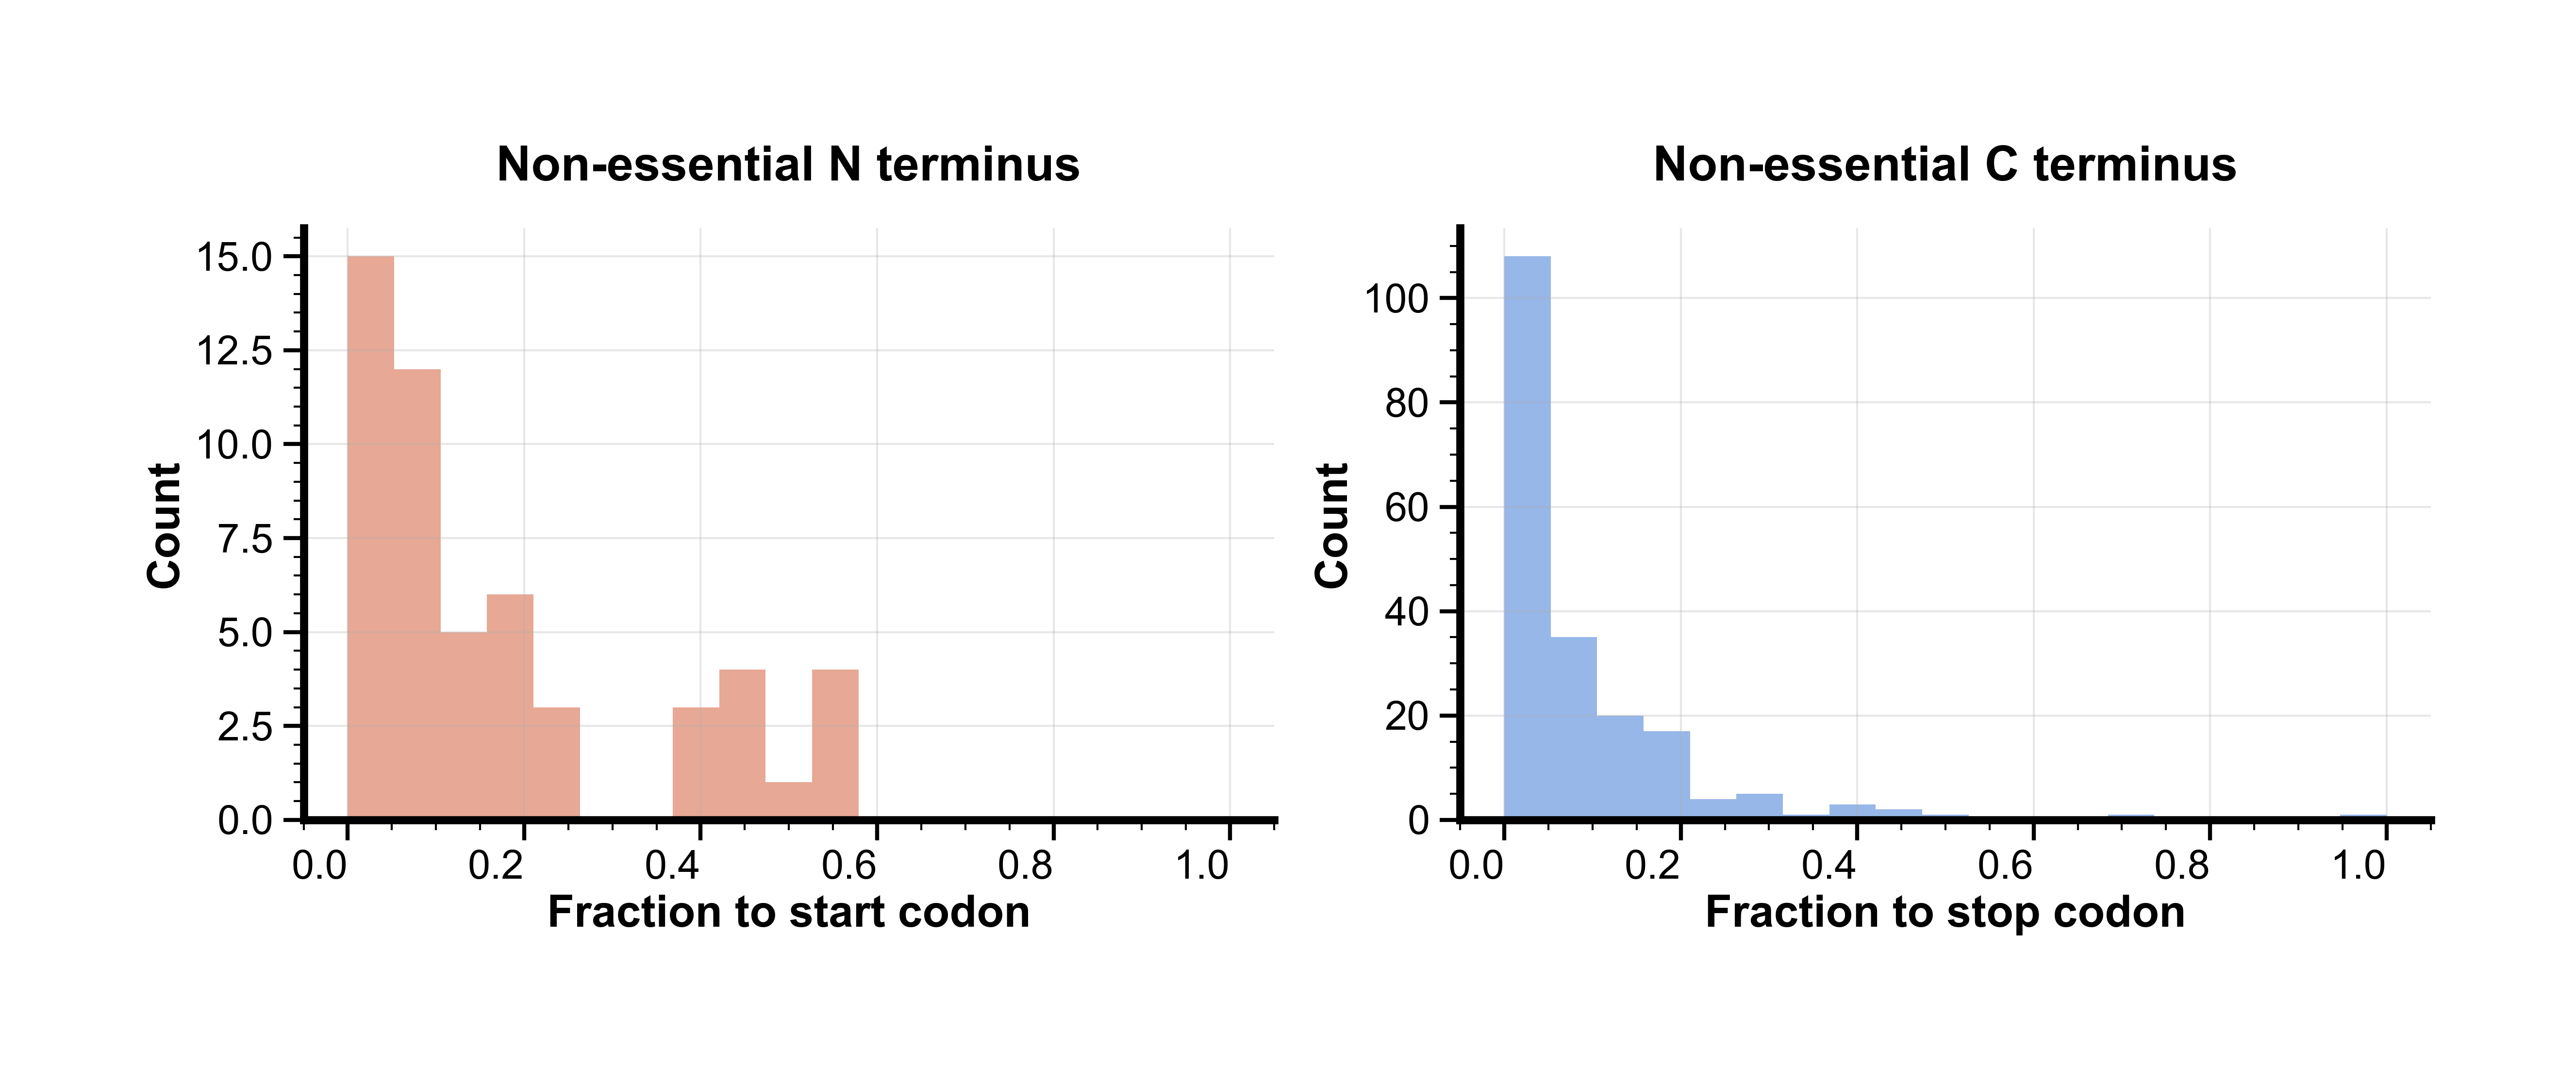

In [9]:
fraction_bins = np.linspace(0,1, 20)

fig, axes = plt.subplots(1,2, figsize=(2*AX_WIDTH, AX_HEIGHT), sharex=True)

annotated_non_essential_N_terminus["AA_fraction_to_start_codon"].hist(bins=fraction_bins, ax=axes[0], color=COLORS[0], alpha=0.7)
axes[0].set_title("Non-essential N terminus")
axes[0].set_xlabel("Fraction to start codon")
axes[0].set_ylabel("Count")

annotated_non_essential_C_terminus["AA_fraction_to_stop_codon"].hist(bins=fraction_bins, ax=axes[1], color=COLORS[1], alpha=0.7)
axes[1].set_title("Non-essential C terminus")
axes[1].set_xlabel("Fraction to stop codon")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
plt.close()

## 5.3 Rank-order plot for the distance to the start/stop codon

In [18]:
annotated_non_essential_N_terminus["Order"] = annotated_non_essential_N_terminus["AA_distance_to_start_codon"].rank(ascending=False, method="first")
annotated_non_essential_C_terminus["Order"] = annotated_non_essential_C_terminus["AA_distance_to_stop_codon"].rank(ascending=False, method="first")

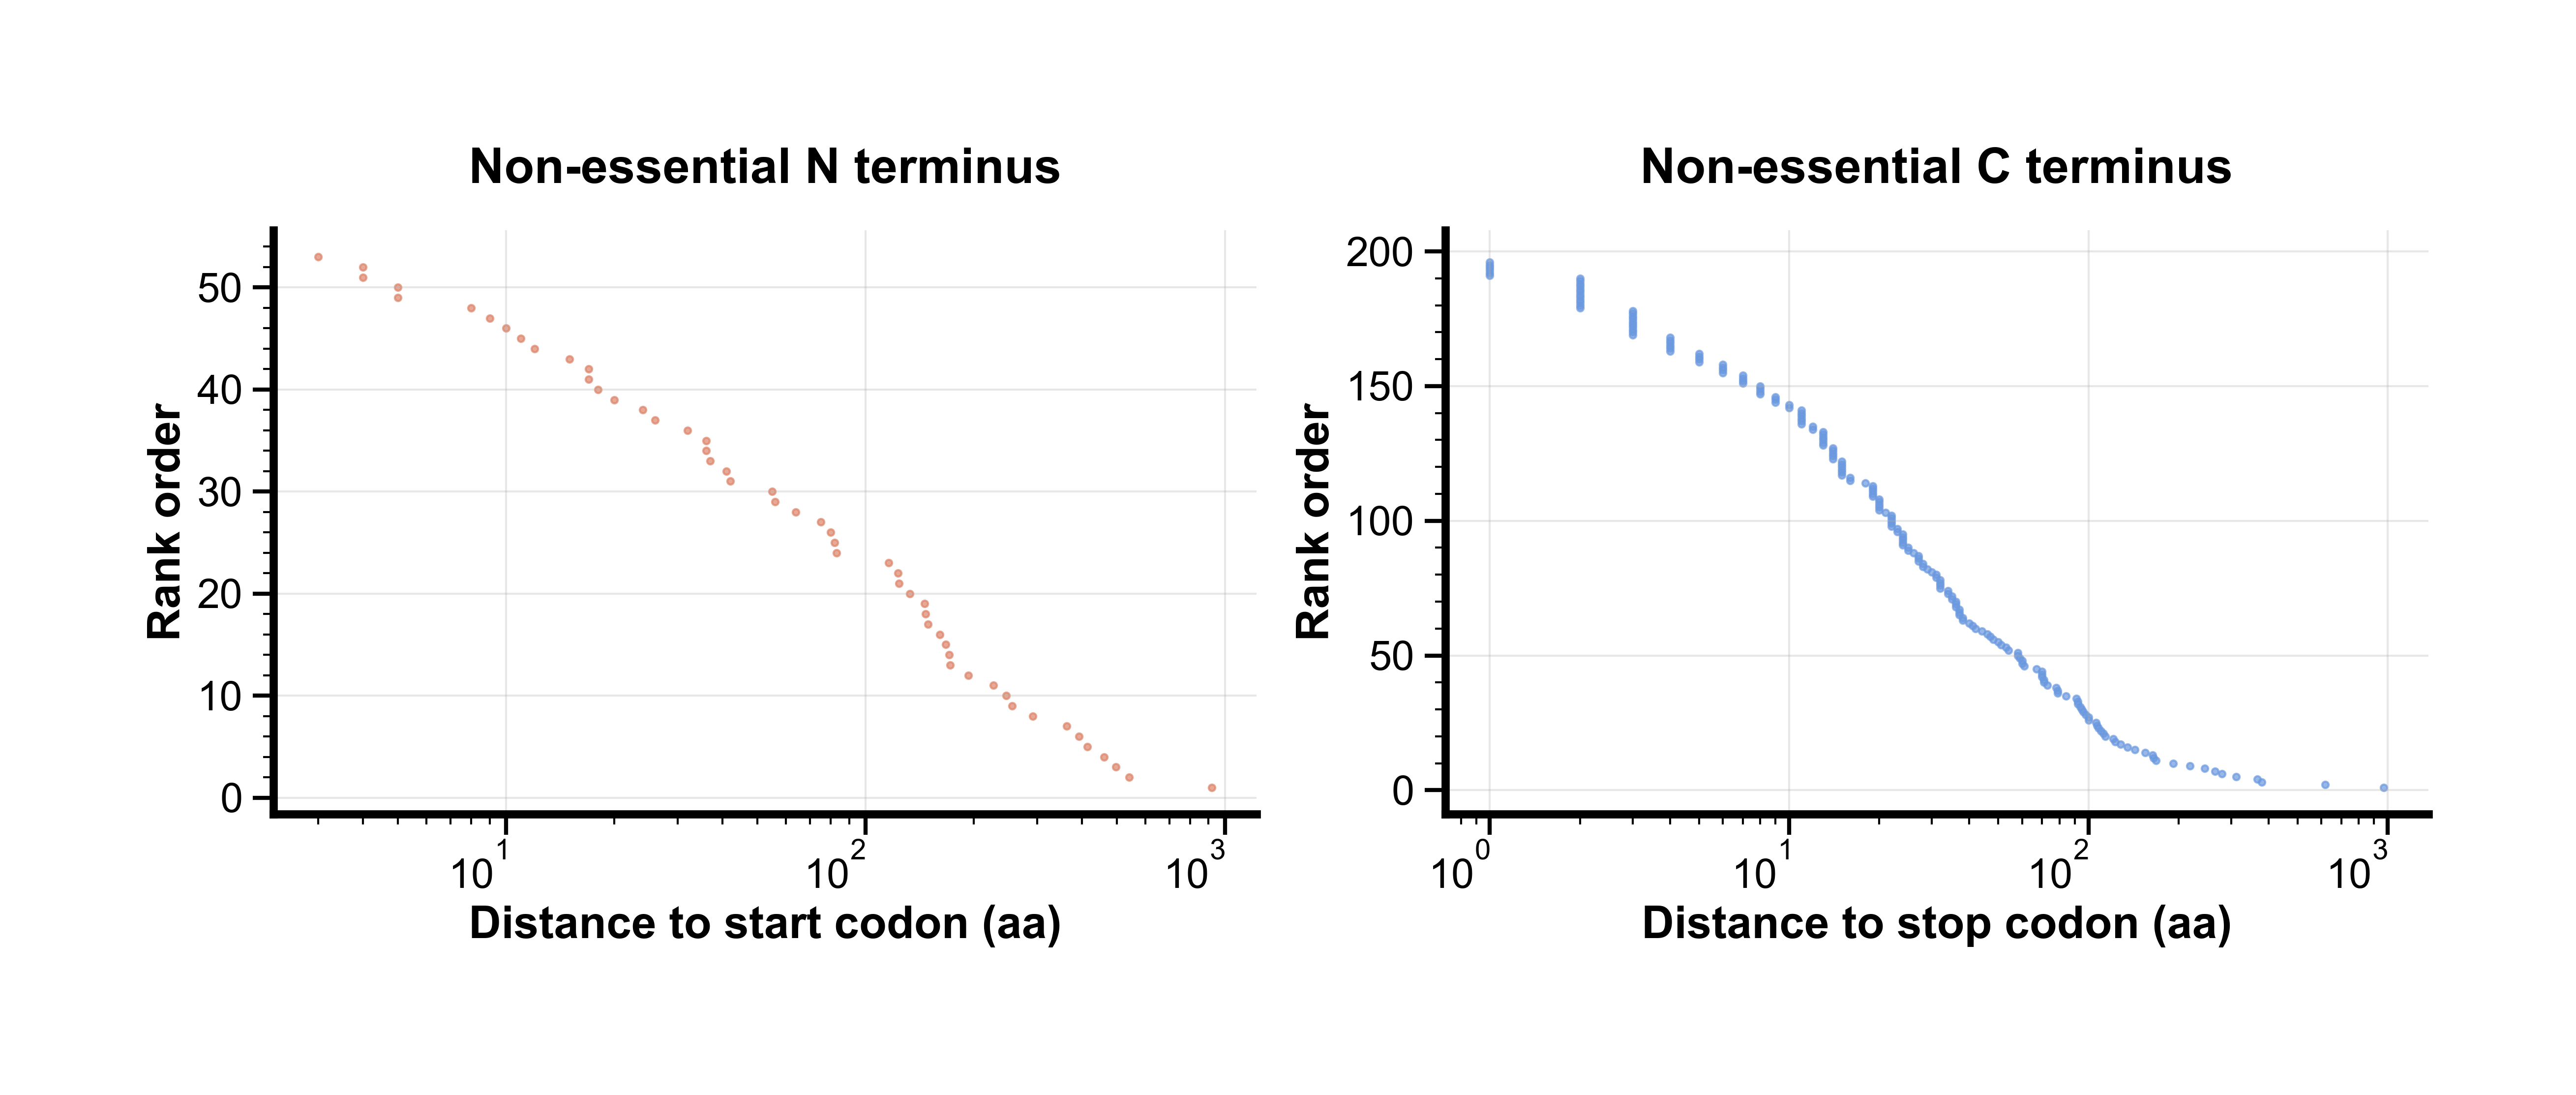

In [23]:
with plt.rc_context({"axes.grid": True}):
    fig, axes = plt.subplots(1,2, figsize=(2*AX_WIDTH, AX_HEIGHT))

    axes[0].scatter(annotated_non_essential_N_terminus["AA_distance_to_start_codon"], annotated_non_essential_N_terminus["Order"], color=COLORS[0], alpha=0.7, s=10)
    axes[0].set_title("Non-essential N terminus")
    axes[0].set_xlabel("Distance to start codon (aa)")
    axes[0].set_xscale("log")
    axes[0].set_ylabel("Rank order")

    axes[1].scatter(annotated_non_essential_C_terminus["AA_distance_to_stop_codon"], annotated_non_essential_C_terminus["Order"], color=COLORS[1], alpha=0.7, s=10)
    axes[1].set_title("Non-essential C terminus")
    axes[1].set_xlabel("Distance to stop codon (aa)")
    axes[1].set_xscale("log")
    axes[1].set_ylabel("Rank order")

    plt.tight_layout()
    plt.show()
    plt.close()

In [10]:
with pd.ExcelWriter(config.output_dir / "non_essential_domains.xlsx") as writer:
    annotated_non_essential_N_terminus.to_excel(writer, sheet_name="Non-essential N terminus", index=False)
    annotated_non_essential_C_terminus.to_excel(writer, sheet_name="Non-essential C terminus", index=False)